# MACCS Training Model

In [51]:
import pandas as pd
import random
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
import selfies as sf
import group_selfies as gsf
from rdkit import Chem

random.seed(42)

In [52]:

import optuna
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    make_scorer,
    roc_curve,
    auc,
    hamming_loss,
    jaccard_score,
)
import matplotlib.pyplot as plt


# Data Processing

In [53]:
chembl_df = pd.read_csv("../../data/ExperimentData/pChEMBL_data.csv")
maccs_df = pd.read_csv("../../data/ExperimentData/pChEMBL_MACCS_fingerprints.csv")
print(chembl_df.head(), chembl_df.shape)
print(maccs_df.head(), maccs_df.shape)

  Molecule ChEMBL ID                                       Smiles  \
0      CHEMBL1643678   Fc1ccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)cc1   
1      CHEMBL1643853  COc1cccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)c1   
2      CHEMBL1643672             c1cc2nc3c(c(N4CCCCC4)n2n1)CCNCC3   
3      CHEMBL2022190          Cl.NC[C@H]1C[C@@H]1c1ccccc1OCC1CCC1   
4      CHEMBL2022193           Cl.NC[C@@H]1C[C@H]1c1ccccc1OCC1CC1   

   pChEMBL Value     Comment  
0           8.52         NaN  
1           7.40         NaN  
2           6.23         NaN  
3            NaN  Not Active  
4            NaN  Not Active   (1281, 4)
  Molecule ChEMBL ID  0  1  2  3  4  5  6  7  8  ...  157  158  159  160  161  \
0      CHEMBL1643678  0  0  0  0  0  0  0  0  1  ...    1    1    0    0    1   
1      CHEMBL1643853  0  0  0  0  0  0  0  0  1  ...    1    1    1    1    1   
2      CHEMBL1643672  0  0  0  0  0  0  0  0  0  ...    0    1    0    0    1   
3      CHEMBL2022190  0  0  0  0  0  0  0  0  0  ...    1    1   

## Remove duplicates

In [54]:
# check if there are duplicated values in the dataframes
print(chembl_df["Molecule ChEMBL ID"].duplicated().sum())
print(maccs_df["Molecule ChEMBL ID"].duplicated().sum())
print(chembl_df.shape, maccs_df.shape)

# remove duplicates
chembl_df_unique = chembl_df.drop_duplicates(subset="Molecule ChEMBL ID")
maccs_df_unique = maccs_df.drop_duplicates(subset="Molecule ChEMBL ID")

# merge features and targets
merge_data = pd.merge(chembl_df_unique, maccs_df_unique, on="Molecule ChEMBL ID", how="left")
print(merge_data.head(), merge_data.shape)


421
421
(1281, 4) (1281, 168)
  Molecule ChEMBL ID                                       Smiles  \
0      CHEMBL1643678   Fc1ccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)cc1   
1      CHEMBL1643853  COc1cccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)c1   
2      CHEMBL1643672             c1cc2nc3c(c(N4CCCCC4)n2n1)CCNCC3   
3      CHEMBL2022190          Cl.NC[C@H]1C[C@@H]1c1ccccc1OCC1CCC1   
4      CHEMBL2022193           Cl.NC[C@@H]1C[C@H]1c1ccccc1OCC1CC1   

   pChEMBL Value     Comment  0  1  2  3  4  5  ...  157  158  159  160  161  \
0           8.52         NaN  0  0  0  0  0  0  ...    1    1    0    0    1   
1           7.40         NaN  0  0  0  0  0  0  ...    1    1    1    1    1   
2           6.23         NaN  0  0  0  0  0  0  ...    0    1    0    0    1   
3            NaN  Not Active  0  0  0  0  0  0  ...    1    1    0    0    1   
4            NaN  Not Active  0  0  0  0  0  0  ...    1    1    0    0    1   

   162  163  164  165  166  
0    1    1    1    1    0  
1    1    1    1

## process the target data -> split to psy and non-psy

In [55]:
filtered_df = merge_data[merge_data["Comment"] != "Not Determined"]
filtered_df.fillna(0, inplace=True)
print(filtered_df.shape)

# check psy ad non-psy number
psy_chembl = filtered_df[filtered_df["pChEMBL Value"] == 0].drop(["Comment"], axis=1)
non_psy_chembl = filtered_df[filtered_df["pChEMBL Value"] != 0].drop(["Comment"], axis=1)

print(psy_chembl.shape)
print(non_psy_chembl.shape)

combine_psy_nonpsy = filtered_df.drop(['Comment'], axis = 1).iloc[:, 2:]
print(combine_psy_nonpsy.head())    

(840, 171)
(277, 170)
(563, 170)
   pChEMBL Value  0  1  2  3  4  5  6  7  8  ...  157  158  159  160  161  \
0           8.52  0  0  0  0  0  0  0  0  1  ...    1    1    0    0    1   
1           7.40  0  0  0  0  0  0  0  0  1  ...    1    1    1    1    1   
2           6.23  0  0  0  0  0  0  0  0  0  ...    0    1    0    0    1   
3           0.00  0  0  0  0  0  0  0  0  0  ...    1    1    0    0    1   
4           0.00  0  0  0  0  0  0  0  0  0  ...    1    1    0    0    1   

   162  163  164  165  166  
0    1    1    1    1    0  
1    1    1    1    1    0  
2    1    1    0    1    0  
3    1    1    1    1    1  
4    1    1    1    1    1  

[5 rows x 168 columns]


/var/folders/qx/gfkzkrms53g36y6nnlpc2t2c0000gn/T/ipykernel_98005/2670068374.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.fillna(0, inplace=True)


# Training

In [56]:
X = combine_psy_nonpsy.iloc[:, 2:]
y_label = (combine_psy_nonpsy.iloc[:, 0] > 0).astype(int)
y_value = combine_psy_nonpsy["pChEMBL Value"]


print(X.shape, y_label.shape, y_value.shape)
print(X.head())
print(y_label.head())


(840, 166) (840,) (840,)
   1  2  3  4  5  6  7  8  9  10  ...  157  158  159  160  161  162  163  164  \
0  0  0  0  0  0  0  0  1  0   0  ...    1    1    0    0    1    1    1    1   
1  0  0  0  0  0  0  0  1  0   0  ...    1    1    1    1    1    1    1    1   
2  0  0  0  0  0  0  0  0  0   0  ...    0    1    0    0    1    1    1    0   
3  0  0  0  0  0  0  0  0  0   0  ...    1    1    0    0    1    1    1    1   
4  0  0  0  0  0  0  0  0  0   0  ...    1    1    0    0    1    1    1    1   

   165  166  
0    1    0  
1    1    0  
2    1    0  
3    1    1  
4    1    1  

[5 rows x 166 columns]
0    1
1    1
2    1
3    0
4    0
Name: pChEMBL Value, dtype: int64


### Single Label

In [57]:
# Nested cross-validation setup
outer_ncv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_ncv = StratifiedKFold(n_splits=5, shuffle=True, random_state=43)


# Define the objective function for the Inner loop
def objective(trial, X_train_inner, y_train_inner):
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    max_depth = trial.suggest_int("max_depth", 5, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Create a random forest classifier
    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42,
    )

    # Cross-validation for hyperparameter tuning
    scoring = make_scorer(accuracy_score, greater_is_better=True)
    cv_scores = cross_val_score(
        rf_classifier, X_train_inner, y_train_inner, cv=inner_ncv, scoring=scoring
    )
    return cv_scores.mean()


[I 2025-01-13 11:23:48,847] A new study created in memory with name: no-name-885ba924-f38d-410c-939a-1900d8d4dd0a
[I 2025-01-13 11:23:49,003] Trial 0 finished with value: 0.7767164179104478 and parameters: {'n_estimators': 21, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 0 with value: 0.7767164179104478.
[I 2025-01-13 11:23:49,254] Trial 1 finished with value: 0.7692868988391377 and parameters: {'n_estimators': 76, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 0 with value: 0.7767164179104478.
[I 2025-01-13 11:23:49,392] Trial 2 finished with value: 0.7737423991155336 and parameters: {'n_estimators': 37, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 0.7767164179104478.
[I 2025-01-13 11:23:49,685] Trial 3 finished with value: 0.791608623548922 and parameters: {'n_estimators': 65, 'max_depth': 19, 'min_samples_split': 2

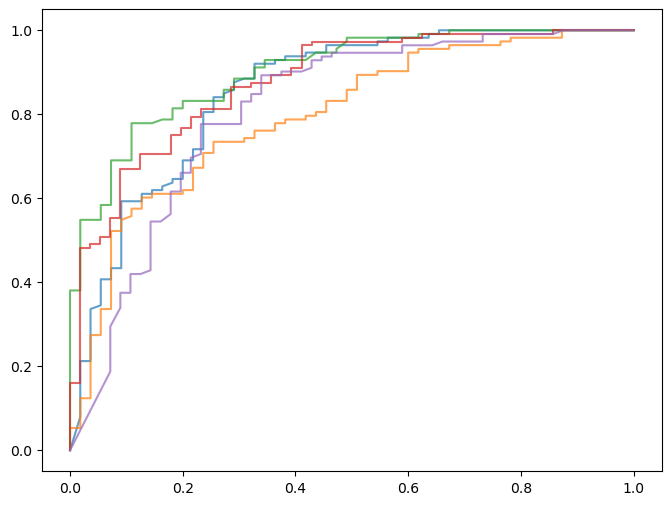

In [58]:
# Outer loop: Statistical evaluation
outer_scores = []
# ncv_label_scores = {label: [] for label in y.columns}

# For ROC plotting
mean_fpr = np.linspace(0, 1, 100)  # Average FPR for interpolation
tprs = []  # TPRs for all folds
aucs = []  # AUC scores for all folds

plt.figure(figsize=(8, 6))  # Initialize the plot

for fold, (train_index, test_index) in enumerate(outer_ncv.split(X, y_label), start=1):
    # Split data into training and testing sets for the outer fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_label.iloc[train_index], y_label.iloc[test_index]

    # Skip fold if only one class is present
    if len(np.unique(y_test)) < 2:
        print(
            f"Fold {fold}: Only one class present in y_test. Skipping ROC computation."
        )
        continue

    # Inner loop: Hyperparameter search
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)

    # Train the model using the best hyperparameters
    best_params = study.best_params
    best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
    best_rf_classifier.fit(X_train, y_train)

    # Predict on the test set
    y_test_pred = best_rf_classifier.predict(X_test)
    y_test_pred_proba = best_rf_classifier.predict_proba(X_test)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Plot ROC curve for the current fold
    plt.plot(fpr, tpr, label=f"Fold {fold} (AUC = {roc_auc:.2f})", alpha=0.7)

    # Interpolate TPR for consistent plotting
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

    # Evaluate the model on the outer fold's test set
    outer_scores.append(
        {
            "accuracy": accuracy_score(y_test, y_test_pred),
            "f1_score": f1_score(y_test, y_test_pred, average="weighted"),
        }
    )


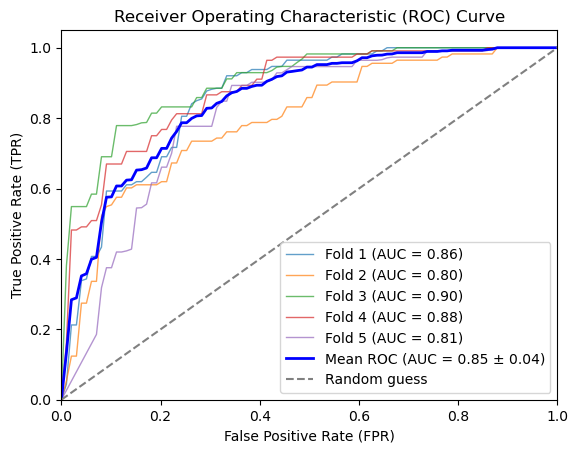

Accuracy: Mean = 0.80, Std = 0.03
F1_score: Mean = 0.80, Std = 0.03
Fold 1:
  accuracy: 0.8274
  f1_score: 0.8218
Fold 2:
  accuracy: 0.7440
  f1_score: 0.7339
Fold 3:
  accuracy: 0.8214
  f1_score: 0.8206
Fold 4:
  accuracy: 0.7976
  f1_score: 0.7945
Fold 5:
  accuracy: 0.8095
  f1_score: 0.8066


In [61]:
# Compute and plot ROC curve for each fold
# plt.figure(figsize=(10, 8))

for fold, tpr in enumerate(tprs, start=1):
    # Plot each fold's ROC curve
    plt.plot(
        mean_fpr,
        tpr,
        lw=1,
        alpha=0.7,
        label=f"Fold {fold} (AUC = {aucs[fold-1]:.2f})",
    )

# Compute and plot mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # Ensure the curve ends at (1, 1)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot the mean ROC curve
plt.plot(
    mean_fpr,
    mean_tpr,
    color="blue",
    lw=2,
    label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
)

# Add reference line and format the plot
plt.plot([0, 1], [0, 1], color="grey", linestyle="--", label="Random guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Calculate mean and standard deviation for overall metrics
metrics_summary = {
    key: [score[key] for score in outer_scores] for key in outer_scores[0]
}
for metric, values in metrics_summary.items():
    print(
        f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
    )

# Print final scores
for i, scores in enumerate(outer_scores):
    print(f"Fold {i+1}:")
    for metric, value in scores.items():
        print(f"  {metric}: {value:.4f}")


In [60]:
print(best_params)
print(outer_scores)

{'n_estimators': 26, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False}
[{'accuracy': 0.8273809523809523, 'f1_score': 0.8217969325564263}, {'accuracy': 0.7440476190476191, 'f1_score': 0.7338572188570032}, {'accuracy': 0.8214285714285714, 'f1_score': 0.8205583402951822}, {'accuracy': 0.7976190476190477, 'f1_score': 0.7945310363686081}, {'accuracy': 0.8095238095238095, 'f1_score': 0.806617445993984}]
